In [1]:
import time
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from prettytable import PrettyTable

In [2]:
x, d = sp.symbols('x d')
bounds = [-1, 1]

# РЕШЕНИЕ КРАЕВЫХ ЗАДАЧ МЕТОДОМ РАЗНОСТНЫХ АППРОКСИМАЦИЙ

## Теория

Рассматриваем уравнение вида:

$$
t(x)\cdot y'' + p(x) \cdot y' + q(x) \cdot y = f(x)
$$

$$
t(x), p(x), q(x), f(x) - непрерывные \ на\  отрезке\  [a, b]\ функции
$$

### Условия для базисной системы

1. $\phi_{0}$ удовлетворяет граничному условию
2. функции $\phi_{1}(x), ..., \phi_{n}(x)$ - линейно независимы на [a, b] и удовлетворяют однородным граничным условиям

Тогда по базисным функция строим приближенное решение в виде линейной комбинации базисный функций:

$$
y_{n} = a_{0}\cdot\phi_{0}(x) + a_{1}\cdot \phi_{1}(x) + ... + a_{n} \cdot \phi_{n}(x)
$$

Задача сводится к выбору $a_{1}, ..., a_{n}$ таких, чтобы $y_{n}(x)$ удовлетворяла граничному условию и приближалась к граничному решению.

Выражение:

$$
\psi(x, a_{1}, ..., a_{n}) = t(x) \cdot y_{n}(x)'' + p(x) \cdot y_{n}(x)' + q(x) \cdot y_{n}(x) - f(x)
$$

Называется невязкой

### Базисные функции вида:

$$
\phi_i = x^{i} \cdot (1 - x^2)
$$

###  Значение коэффициентов $a_i$ в невязке

Значение коэффициентов в матрице может быть найдена по следующей формуле:

$$
a_i = t(x) \cdot \phi_i'' + p(x) \cdot \phi_i' + q(x) \cdot \phi_i
$$

Свободные члены можно найти по следующей формуле:

$$
b_i = f(x)
$$

In [3]:
base_expr = x**d * (1 - x**2)
base_func = sp.lambdify((x, d), base_expr)
ai_expr = 0
ai = 0

In [4]:
t = sp.lambdify(x, 1)
p = sp.lambdify(x, 0)
q = sp.lambdify(x, 1 + x**2)
f = sp.lambdify(x, -1)

## Способы решение краевой задачи

### Метод коллокаций

На отрезке $[a, b]$ выбирается $m$ точек $x_{1}, ..., x_{n}$ $(m \geq n)$

Эти точки последовательно подставляются в невязку, считаю, что она должна быть равна `0`

Обычно берётся `m = n` и решается система из `n` уравнений и `n` неизвестных

#### Формулы

Каждый элемент матрицы может просто найди, используя формулы для нахождения $a_i$:


$ matrix_{i, j} = a_j(x_i) $, где $x_i$ - $i$-я точка

А вектор свободных членов:

$ b_i = f(x_i) $

In [5]:
def collacation_method(n):
    # b in general
    expr = f(x)
    bi = sp.lambdify(x, expr)
    xs = np.linspace(*bounds, n + 2 + n % 2)[1:-1 - n % 2]
#     xs = np.linspace(*bounds, n + 2)[1:-1]
    matrix = np.zeros(shape=(n, n))
    b = np.zeros(shape=(n, 1))
    for i in range(n):
        for j in range(n):
            matrix[i][j] = ai(xs[i], j)
        b[i] = bi(xs[i])
    return np.linalg.solve(matrix, b)

### Дискретный МНК

Выбирается $N > n$ точек и решается задача минимизации:

$$
S = \sum_{i=1}^{N}\psi^2(x_i, a_1, ..., a_n)
$$

Для её решение решается система:

$$
\frac{dS}{d a_1} = 0
$$
$$
.......
$$
$$
\frac{dS}{d a_n} = 0
$$

#### Формулы

В результате возведения в квадрат и взятия производной коэффициенты в матрицы могут быть найдены по следующей формуле:

$$
matrix_{i, j} = \sum_{p = 0}^{pointsAmount} a_i(x_p) \cdot a_j(x_p)
$$

А вектор свободных членов:

$$
b_i = \sum_{p = 0}^{pointsAmount} a_i(x_p) \cdot f(x_p)
$$

In [6]:
def discrete_LSM_method(n):
    points_amount = int(input('Количество точек для дискретного МНК: '))
    points = np.linspace(*bounds, points_amount + points_amount % 2)
    expr = ai_expr * f(x)
    bi = sp.lambdify((x, d), expr)
    
    matrix = np.zeros(shape=(n, n))
    b = np.zeros(shape=(n, 1))
    
    # fill a half of matrix
    for i in range(n):
        for j in range(i + 1):
            matrix[i][j] = sum(ai(p, i) * ai(p, j) for p in points)
        b[i] = sum(bi(p, i) for p in points)
    
    # copy values for another half of matrix
    for i in range(n):
        for j in range(n-1, i, -1):
            matrix[i][j] = matrix[j][i]

    return np.linalg.solve(matrix, b)

### Метод Галёркина

Рассматриваем невязку $\psi$ и для определения коэффициентов $a_1, ..., a_n$ решаем систему:


$$
\int_a^b\psi(x, a_1, ..., a_n)\cdot \psi_1(x)dx = 0
$$
$$
................................
$$
$$
\int_a^b\psi(x, a_1, ..., a_n)\cdot \psi_n(x)dx = 0
$$


#### Формулы

Коэффициенты для каждого элемента матрицы можно найти по следующей формуле:

$$
matrix_{i,j} = \int_a^b a_j(x) \cdot \phi_i(x) dx
$$

Интегрировать будем численным интегрированием, используя метод трапеций из $numpy$

Вектор свободных членов можно найти так:

$$
b_i = \int_a^b f(x) \cdot \phi_i(x) dx
$$

In [7]:
def galerkin_method(n):
    d1, d2 = sp.symbols('d1 d2')
    expr = ai(x, d1) * base_func(x, d2)
    func = sp.lambdify((x, d1, d2), expr)
    
    bi_expr = base_func(x, d) * f(x)
    bi = sp.lambdify((x, d), bi_expr)
    
    matrix = np.zeros(shape=(n, n))
    b = np.zeros(shape=(n, 1))
    
    points = np.linspace(*bounds, 100)
    for i in range(n):
        for j in range(n):
            matrix[i][j] = np.trapz(np.array([func(p, j, i) for p in points]))
        b[i] = np.trapz(np.array([bi(p, i) for p in points]))
        
    return np.linalg.solve(matrix, b)

# Solver

In [8]:
def solver(tt, pp, qq, ff):
    n = int(input('Количество базисных функций: '))
    # functions to solve
    solvers = [collacation_method, discrete_LSM_method, galerkin_method]
    # basics
    global t, p, q, f, ai, ai_expr
    t = sp.lambdify(x, tt)
    p = sp.lambdify(x, pp)
    q = sp.lambdify(x, qq)
    f = sp.lambdify(x, ff)
    ai_expr = t(x) * sp.diff(base_expr, x, x) + p(x) * sp.diff(base_expr, x) + q(x) * base_expr
    ai = sp.lambdify((x, d), ai_expr)
    
    table = PrettyTable()
    table.field_names = ['Method', 'Max y', 'Time']
    for num, func in enumerate(solvers):
        start = time.time()
        ans = func(n)
        end = time.time()
        expr = 0
        for i in range(len(ans)):
            expr += ans[i] * (x**(i) - x**(i+2))
        func = sp.lambdify(x, expr)
        xs = np.linspace(*bounds)
        ys = np.array([func(xi) for xi in xs])
        plt.plot(xs, ys, label=solvers[num].__name__)
        
        table.add_row([
            solvers[num].__name__, 
            round(max(abs(ys))[0], 3), 
            round(end - start, 3)
        ])
        
    print(table)
        
    plt.grid()
    plt.legend()
    plt.show()

Количество базисных функций: 100
Количество точек для дискретного МНК: 500
+---------------------+-------+--------+
|        Method       | Max y |  Time  |
+---------------------+-------+--------+
|  collacation_method | 1.109 | 0.037  |
| discrete_LSM_method | 1.109 | 17.822 |
|   galerkin_method   | 1.109 | 3.859  |
+---------------------+-------+--------+


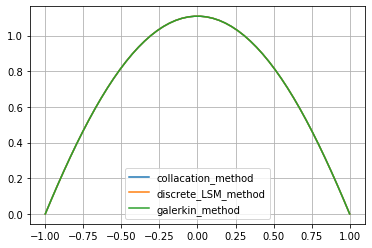

In [10]:
solver(np.sin(2), 0, 1 + np.sin(2) * x**2, -1)

#### Helper functions

In [47]:
def plot_solution(ai):
    expr = 0
    for i in range(len(ai)):
        expr += ai[i] * (x**(i) - x**(i+2))
    func = sp.lambdify(x, expr)
    xs = np.linspace(*bounds)
    ys = np.array([func(xi) for xi in xs])
    print(max(abs(ys)))
    plt.plot(xs, ys)
    plt.grid()
    plt.show()
    